<a href="https://colab.research.google.com/gist/barronh/b63731fed5cf4fd5c2d79d5545353920/goes16_custom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom GOES-16 GOES-17 AOD Processing

    author: Barron H. Henderson
    date: 2023-05-08

Download, process, and plot GOES-R L2 Channel Radiances, AODC and L1b. Produce a figure that is comparable to NOAA's AerosolWatch website. https://www.star.nesdis.noaa.gov/smcd/spb/aq/AerosolWatch

# Installing Package

Google Colab needs netcdf4 to be installed. If you are not on Google Colab, skip this step. Otherwise, run teh command below to install `netcdf4` for netcdf file read.

To make quick easy map overlays, I am including pycno. pycno allows you to use NASA overlay formats to add coastlines, countries, and states to maps. It is very light weight compared to basemap or cartopy.

In [2]:
!pip install -qq h5netcdf pyproj s3fs geopandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.1/160.1 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 490.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 8.7 MB/s eta 0:00:00


# Import Packages

Not import all libraries that will be used.


* `warnings` is used to warn when cahced files are used
* `xarray` is used for netcdf file manipulation and plotting. This implicitly uses `netcdf4` from above.
* `numpy` is used for numeric array manipulation
* `pandas` and `geopandas` are used for CSV and shapefiles
* `matplotlib` is used for plotting functions.


In [3]:
import matplotlib.pyplot as plt
import warnings
import s3fs
import xarray as xr
import pyproj
import pandas as pd
import geopandas as gpd
import numpy as np


# Grab States and Counties for Plotting Later

In [4]:
!wget -N https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_5m.zip
!wget -N https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip
cb = gpd.read_file('cb_2018_us_county_5m.zip')
sb = gpd.read_file('cb_2018_us_state_500k.zip')

--2023-05-08 17:32:55--  https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_5m.zip
Resolving www2.census.gov (www2.census.gov)... 104.66.235.36, 2600:1408:7:1bd::208c, 2600:1408:7:191::208c
Connecting to www2.census.gov (www2.census.gov)|104.66.235.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘cb_2018_us_county_5m.zip’

cb_2018_us_county_5     [ <=>                ]   2.65M  14.3MB/s    in 0.2s    

2023-05-08 17:32:56 (14.3 MB/s) - ‘cb_2018_us_county_5m.zip’ saved [2781997]

--2023-05-08 17:32:56--  https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip
Resolving www2.census.gov (www2.census.gov)... 104.66.235.36, 2600:1408:7:1bd::208c, 2600:1408:7:191::208c
Connecting to www2.census.gov (www2.census.gov)|104.66.235.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘cb_2018_us_state_500k.zip’

cb_2018_us_state_50  

# Explore Data on AWS

In [5]:
awsfs = s3fs.S3FileSystem(anon=True)

In [6]:
awsfs.ls('noaa-goes16/')

['noaa-goes16/ABI-L1b-RadC',
 'noaa-goes16/ABI-L1b-RadF',
 'noaa-goes16/ABI-L1b-RadM',
 'noaa-goes16/ABI-L2-ACHA2KMC',
 'noaa-goes16/ABI-L2-ACHA2KMF',
 'noaa-goes16/ABI-L2-ACHA2KMM',
 'noaa-goes16/ABI-L2-ACHAC',
 'noaa-goes16/ABI-L2-ACHAF',
 'noaa-goes16/ABI-L2-ACHAM',
 'noaa-goes16/ABI-L2-ACHP2KMC',
 'noaa-goes16/ABI-L2-ACHP2KMF',
 'noaa-goes16/ABI-L2-ACHP2KMM',
 'noaa-goes16/ABI-L2-ACHTF',
 'noaa-goes16/ABI-L2-ACHTM',
 'noaa-goes16/ABI-L2-ACMC',
 'noaa-goes16/ABI-L2-ACMF',
 'noaa-goes16/ABI-L2-ACMM',
 'noaa-goes16/ABI-L2-ACTPC',
 'noaa-goes16/ABI-L2-ACTPF',
 'noaa-goes16/ABI-L2-ACTPM',
 'noaa-goes16/ABI-L2-ADPC',
 'noaa-goes16/ABI-L2-ADPF',
 'noaa-goes16/ABI-L2-ADPM',
 'noaa-goes16/ABI-L2-AICEF',
 'noaa-goes16/ABI-L2-AITAF',
 'noaa-goes16/ABI-L2-AODC',
 'noaa-goes16/ABI-L2-AODF',
 'noaa-goes16/ABI-L2-BRFC',
 'noaa-goes16/ABI-L2-BRFF',
 'noaa-goes16/ABI-L2-BRFM',
 'noaa-goes16/ABI-L2-CMIPC',
 'noaa-goes16/ABI-L2-CMIPF',
 'noaa-goes16/ABI-L2-CMIPM',
 'noaa-goes16/ABI-L2-COD2KMF',
 'noa

Choose a date and space of interest. Make the map box bigger than the databox

In [8]:
date = pd.to_datetime('2023-03-08T17:00:00+0000')
mapbbox_lonlat = (-90, 25, -75, 40)
bbox_lonlat = (-85.5, 31, -83, 33)

# AOD Example Plot

In [9]:
aodpaths = awsfs.ls(f'noaa-goes16/ABI-L2-AODC/{date:%Y/%j/%H}')
aodpaths

['noaa-goes16/ABI-L2-AODC/2023/067/17/OR_ABI-L2-AODC-M6_G16_s20230671711171_e20230671713544_c20230671716186.nc',
 'noaa-goes16/ABI-L2-AODC/2023/067/17/OR_ABI-L2-AODC-M6_G16_s20230671716171_e20230671718544_c20230671721268.nc',
 'noaa-goes16/ABI-L2-AODC/2023/067/17/OR_ABI-L2-AODC-M6_G16_s20230671721171_e20230671723544_c20230671726328.nc',
 'noaa-goes16/ABI-L2-AODC/2023/067/17/OR_ABI-L2-AODC-M6_G16_s20230671726171_e20230671728544_c20230671731228.nc',
 'noaa-goes16/ABI-L2-AODC/2023/067/17/OR_ABI-L2-AODC-M6_G16_s20230671731171_e20230671733544_c20230671736300.nc',
 'noaa-goes16/ABI-L2-AODC/2023/067/17/OR_ABI-L2-AODC-M6_G16_s20230671736171_e20230671738544_c20230671741168.nc',
 'noaa-goes16/ABI-L2-AODC/2023/067/17/OR_ABI-L2-AODC-M6_G16_s20230671741171_e20230671743544_c20230671746046.nc',
 'noaa-goes16/ABI-L2-AODC/2023/067/17/OR_ABI-L2-AODC-M6_G16_s20230671746171_e20230671748544_c20230671751157.nc',
 'noaa-goes16/ABI-L2-AODC/2023/067/17/OR_ABI-L2-AODC-M6_G16_s20230671751171_e20230671753544_c202

In [18]:
fo = awsfs.open(aodpaths[1])

In [19]:
ds = xr.open_dataset(fo, engine='h5netcdf')
# Convert x/y from radians to x
h = ds['goes_imager_projection'].attrs['perspective_point_height']
ds.coords['x'] = ds['x'] * h
ds.coords['y'] = ds['y'] * h

In [23]:
proj = pyproj.Proj(pyproj.CRS.from_cf(ds['goes_imager_projection'].attrs))
bbox_xy = proj(bbox_lonlat[0], bbox_lonlat[1])
bbox_xy += proj(bbox_lonlat[2], bbox_lonlat[3])
bbox_xy

(-966105.8604694902, 3168995.264621943, -720198.6969389474, 3343396.6886203517)

In [24]:
ds['DQF']

<xarray.DataArray 'DQF' (y: 1500, x: 2500)>
array([[nan, nan, nan, ...,  3.,  3.,  3.],
       [nan, nan, nan, ...,  3.,  3.,  3.],
       [nan, nan, nan, ...,  3.,  3.,  3.],
       ...,
       [ 3.,  3.,  3., ...,  1.,  1.,  1.],
       [ 3.,  3.,  3., ...,  1.,  0.,  1.],
       [ 3.,  3.,  3., ...,  0.,  0.,  1.]], dtype=float32)
Coordinates:
    t                                datetime64[ns] ...
  * y                                (y) float64 4.588e+06 ... 1.584e+06
  * x                                (x) float64 -3.626e+06 ... 1.382e+06
    y_image                          float32 ...
    x_image                          float32 ...
    sunglint_angle                   float32 ...
    retrieval_local_zenith_angle     float32 ...
    quantitative_local_zenith_angle  float32 ...
    retrieval_solar_zenith_angle     float32 ...
    quantitative_solar_zenith_angle  float32 ...
    aod_product_wavelength           float32 ...
Attributes: (12/13)
    long_name:                            ABI L2+ Aerosol Optical Depth at 55...
    standard_name:                        status_flag
    valid_range:                          [0 3]
    units:                                1
    grid_mapping:                         goes_imager_projection
    cell_methods:                         sunglint_angle: point (no retrieval...
    ...                                   ...
    flag_meanings:                        high_quality_retrieval_qf medium_qu...
    number_of_qf_values:                  4
    percent_high_quality_retrieval_qf:    0.1216988
    percent_medium_quality_retrieval_qf:  0.0666473
    percent_low_quality_retrieval_qf:     0.099898
    percent_no_retrieval_qf:              0.711756

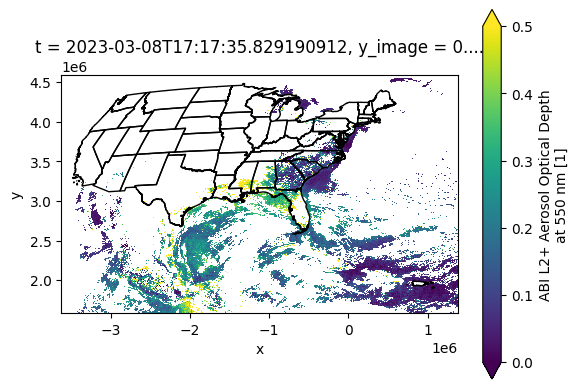

In [25]:
qm = ds['AOD'].where(ds['DQF'] <= 1).plot(vmin=0, vmax=0.5, cmap='viridis')
sb.to_crs(proj.srs).plot(facecolor='none', edgecolor='k', ax=qm.axes);

<Axes: title={'center': 't = 2023-03-08T17:17:35.829190912, y_image = 0....'}, xlabel='x', ylabel='y'>

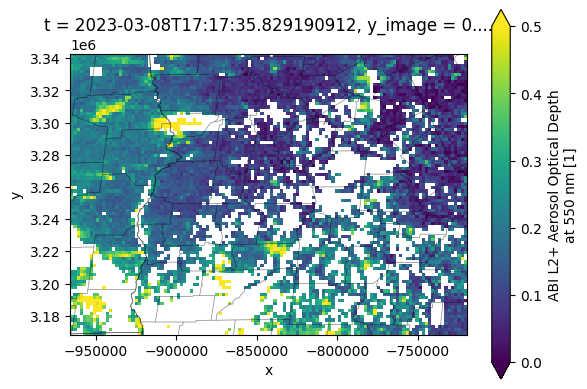

In [34]:
qm = ds['AOD'].where(ds['DQF'] <= 1).sel(
    x=slice(bbox_xy[0], bbox_xy[2]),
    y=slice(bbox_xy[3], bbox_xy[1])
).plot(vmin=0, vmax=0.5, cmap='viridis')
cb.clip(mapbbox_lonlat).to_crs(proj.srs).plot(
    facecolor='none', edgecolor='k', linewidth=0.5, alpha=0.25, ax=qm.axes
)
sb.clip(mapbbox_lonlat).to_crs(proj.srs).plot(
    facecolor='none', edgecolor='k', linewidth=0.5, alpha=0.25, ax=qm.axes
)

# Color Example using L2 MCMIPC

The L2 MCMIPC files have all color channels in a single file.
* Usefully, also on the same grid.
* Channel 1 and 3 were at 2x AODC
* Coarsened Channel 2 to match Channel 

In [27]:
mcmippaths = awsfs.ls(f'noaa-goes16/ABI-L2-MCMIPC/{date:%Y/%j/%H}')
mcmippaths

['noaa-goes16/ABI-L2-MCMIPC/2023/067/17/OR_ABI-L2-MCMIPC-M6_G16_s20230671716171_e20230671718546_c20230671719066.nc',
 'noaa-goes16/ABI-L2-MCMIPC/2023/067/17/OR_ABI-L2-MCMIPC-M6_G16_s20230671721171_e20230671723550_c20230671724094.nc',
 'noaa-goes16/ABI-L2-MCMIPC/2023/067/17/OR_ABI-L2-MCMIPC-M6_G16_s20230671726171_e20230671728559_c20230671729062.nc',
 'noaa-goes16/ABI-L2-MCMIPC/2023/067/17/OR_ABI-L2-MCMIPC-M6_G16_s20230671731171_e20230671733550_c20230671734083.nc',
 'noaa-goes16/ABI-L2-MCMIPC/2023/067/17/OR_ABI-L2-MCMIPC-M6_G16_s20230671736171_e20230671738556_c20230671739082.nc',
 'noaa-goes16/ABI-L2-MCMIPC/2023/067/17/OR_ABI-L2-MCMIPC-M6_G16_s20230671741171_e20230671743548_c20230671744097.nc',
 'noaa-goes16/ABI-L2-MCMIPC/2023/067/17/OR_ABI-L2-MCMIPC-M6_G16_s20230671746171_e20230671748544_c20230671749062.nc',
 'noaa-goes16/ABI-L2-MCMIPC/2023/067/17/OR_ABI-L2-MCMIPC-M6_G16_s20230671751171_e20230671753556_c20230671754086.nc',
 'noaa-goes16/ABI-L2-MCMIPC/2023/067/17/OR_ABI-L2-MCMIPC-M6_G16_

In [28]:
foc = awsfs.open(mcmippaths[0])
dsc = xr.open_dataset(foc, engine='h5netcdf')
# Convert x/y from radians to x
h = dsc['goes_imager_projection'].attrs['perspective_point_height']
dsc.coords['x'] = dsc['x'] * h
dsc.coords['y'] = dsc['y'] * h
dsc

<xarray.Dataset>
Dimensions:                                 (y: 1500, x: 2500,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2, band: 1)
Coordinates: (12/37)
    t                                       datetime64[ns] ...
  * y                                       (y) float64 4.588e+06 ... 1.584e+06
  * x                                       (x) float64 -3.626e+06 ... 1.382e+06
    y_image                                 float32 ...
    x_image                                 float32 ...
    band_wavelength_C01                     (band) float32 ...
    ...                                      ...
    band_id_C11                             (band) int8 ...
    band_id_C12                             (band) int8 ...
    band_id_C13                             (band) int8 ...
    band_id_C14                             (band) int8 ...
    band_id_C15                             (band) int8 ...
    band_id_C16                             (band) int8 ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                band
Data variables: (12/124)
    CMI_C01                                 (y, x) float32 ...
    DQF_C01                                 (y, x) float32 ...
    CMI_C02                                 (y, x) float32 ...
    DQF_C02                                 (y, x) float32 ...
    CMI_C03                                 (y, x) float32 ...
    DQF_C03                                 (y, x) float32 ...
    ...                                      ...
    mean_brightness_temperature_C16         float32 ...
    std_dev_brightness_temperature_C16      float32 ...
    percent_uncorrectable_GRB_errors        float32 ...
    percent_uncorrectable_L0_errors         float32 ...
    dynamic_algorithm_input_data_container  int32 ...
    algorithm_product_version_container     int32 ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    date_created:              2023-03-08T17:19:06.6Z
    time_coverage_start:       2023-03-08T17:16:17.1Z
    time_coverage_end:         2023-03-08T17:18:54.6Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        3de7fdfe-ba15-4887-9cea-69c433902434

In [29]:
proj = pyproj.Proj(pyproj.CRS.from_cf(dsc['goes_imager_projection'].attrs))
bbox_xy = proj(bbox_lonlat[0], bbox_lonlat[1])
bbox_xy += proj(bbox_lonlat[2], bbox_lonlat[3])
bbox_xy

(-966105.8604694902, 3168995.264621943, -720198.6969389474, 3343396.6886203517)

In [35]:
chda = xr.concat(
    [
        da.sel(
            x=slice(bbox_xy[0], bbox_xy[2]),
            y=slice(bbox_xy[3], bbox_xy[1])
        )
        for da in [dsc.CMI_C02, dsc.CMI_C03, dsc.CMI_C01]
    ],
    dim='band'
).transpose('y', 'x', 'band')

In [36]:
gamma = 1.8
coda = np.clip(chda, 0, 1)**(1 / gamma)
# Optionally apply PseudoGreen
coda[:, :, 1] = np.clip(0.45 * coda[:, :, 0] + 0.1 * coda[:, :, 1] + 0.45 * coda[:, :, 2], 0, 1)

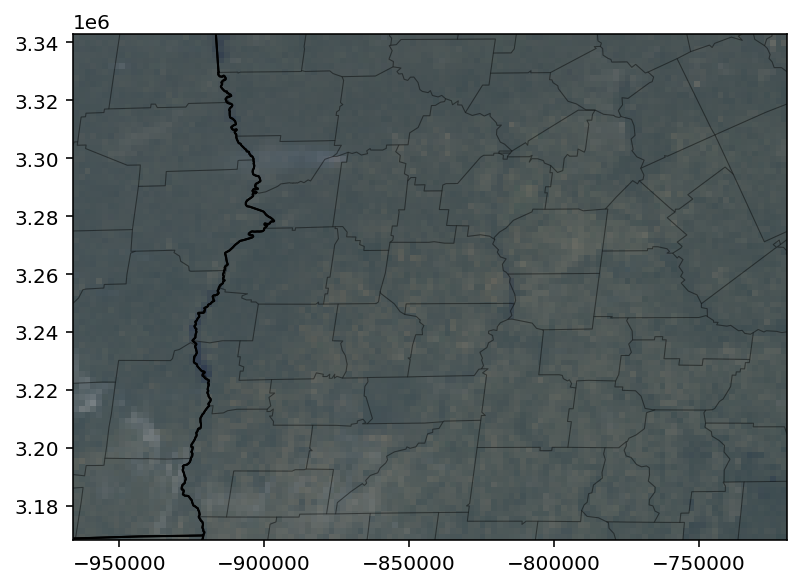

In [37]:
fig, ax = plt.subplots(dpi=144)
ax.pcolormesh(
  coda.x, coda.y, coda.values
)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
#tcno.drawstates()
cb.clip(mapbbox_lonlat).to_crs(proj.srs).plot(facecolor='none', edgecolor='k', ax=ax, alpha=0.25, linewidth=0.5)
sb.clip(mapbbox_lonlat).to_crs(proj.srs).plot(facecolor='none', edgecolor='k', ax=ax)
ax.set(xlim=xlim, ylim=ylim, aspect=1);

# Color with L1b

* Using native Channel 2 resolution
* Interpolating Channel 1 and 3 to Channel 2.
* Using extremely simplistic conversion to color

In [38]:
radpaths = awsfs.ls(f'noaa-goes16/ABI-L1b-RadC/{date:%Y/%j/%H}')
radc01paths = [p for p in radpaths if 'C01' in p]
radc02paths = [p for p in radpaths if 'C02' in p]
radc03paths = [p for p in radpaths if 'C03' in p]

In [39]:
foc1 = awsfs.open(radc01paths[0])
# First Channel 2 file was all masked, so got second
foc2 = awsfs.open(radc02paths[1])
foc3 = awsfs.open(radc03paths[2])

In [40]:
dsc1 = xr.open_dataset(foc1, engine='h5netcdf')
h = dsc1['goes_imager_projection'].attrs['perspective_point_height']
dsc1.coords['x'] = dsc1['x'] * h
dsc1.coords['y'] = dsc1['y'] * h
dsc2 = xr.open_dataset(foc2, engine='h5netcdf')
h = dsc2['goes_imager_projection'].attrs['perspective_point_height']
dsc2.coords['x'] = dsc2['x'] * h
dsc2.coords['y'] = dsc2['y'] * h
dsc3 = xr.open_dataset(foc3, engine='h5netcdf')
h = dsc3['goes_imager_projection'].attrs['perspective_point_height']
dsc3.coords['x'] = dsc3['x'] * h
dsc3.coords['y'] = dsc3['y'] * h


In [43]:
proj = pyproj.Proj(pyproj.CRS.from_cf(dsc1['goes_imager_projection'].attrs))
bbox_xy = proj(bbox_lonlat[0], bbox_lonlat[1])
bbox_xy += proj(bbox_lonlat[2], bbox_lonlat[3])
bbox_xy

(-966105.8604694902, 3168995.264621943, -720198.6969389474, 3343396.6886203517)

In [44]:
refc = dsc2.Rad.sel(
    x=slice(bbox_xy[0], bbox_xy[2]),
    y=slice(bbox_xy[3], bbox_xy[1])
)
# All values are really between 0 and 1000, so normalizing by 1000
# Channel 2 has twice the bin-width, so divide by 2000
rgb = xr.concat([refc / 1000, dsc3.Rad.interp_like(refc) / 1000, dsc1.Rad.interp_like(refc) / 1000], dim='band').transpose('y', 'x', 'band')

In [45]:
gamma = 2.2
coda = np.clip(rgb, 0, 1)**(1 / gamma)
coda[:, :, 1] = np.clip(coda[:, :, 0] * 0.45 + coda[:, :, 1] * 0.1 + coda[:, :, 2] * 0.45, 0, 1)

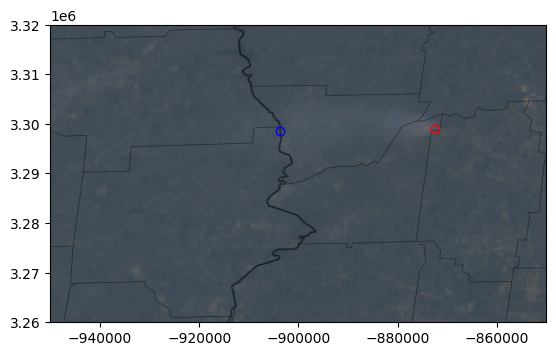

In [46]:
fig, ax = plt.subplots()
ax.pcolormesh(
    coda.x, coda.y,
    coda.transpose('y', 'x', 'band')
)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
cb.query('STATEFP in ("13", "01", "12")').to_crs(proj.srs).plot(facecolor='none', edgecolor='k', ax=ax, alpha=0.25, linewidth=0.5)
sb.query('STATEFP in ("13", "01", "12")').to_crs(proj.srs).plot(facecolor='none', edgecolor='k', ax=ax, alpha=0.25, linewidth=1)
#ax.set(xlim=xlim, ylim=ylim);
ax.set(xlim=(-0.95e6, -.85e6), ylim=(3.26e6, 3.32e6));
# Add custom dots
ax.plot(*proj(-85, 32.5), marker='o', markeredgecolor='blue', markerfacecolor='none', alpha=1)
ax.plot(*proj(-84.65, 32.5), marker='o', markeredgecolor='red', markerfacecolor='none', alpha=1)